In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = [10, 10]

from sklearn import preprocessing
from scipy import interp

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis

# Loading Dataset

In [0]:
dataset = np.genfromtxt('dataset.csv', delimiter=',')[1:]
X = dataset[:, :-1] # features
y = dataset[:,  -1] # target (0 or 1)

# Data Visualisation
trying to find something usefull

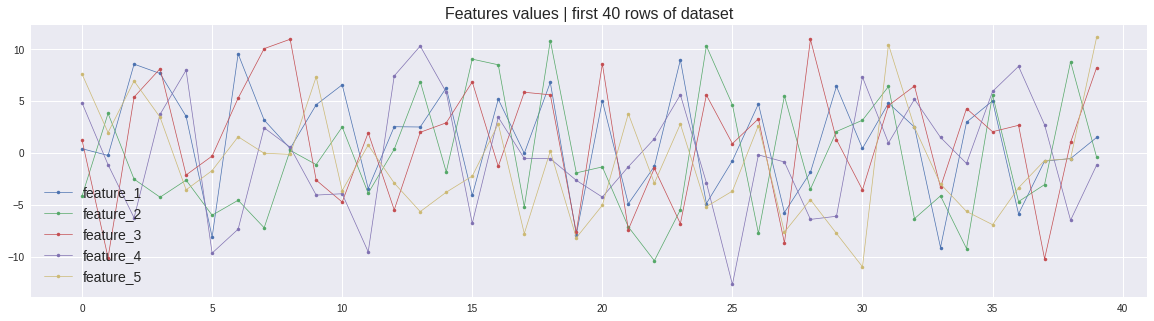

In [270]:
plt.figure(figsize=(20,5))
lw = 0.7
n = 40

plt.plot(X[:n, 0], '.-', lw=lw, label='feature_1')
plt.plot(X[:n, 1], '.-', lw=lw, label='feature_2')
plt.plot(X[:n, 2], '.-', lw=lw, label='feature_3')
plt.plot(X[:n, 3], '.-', lw=lw, label='feature_4')
plt.plot(X[:n, 4], '.-', lw=lw, label='feature_5')

plt.title(f'Features values | first {n} rows of dataset', fontsize=16)
plt.legend(prop = {'size': 14})
plt.show()

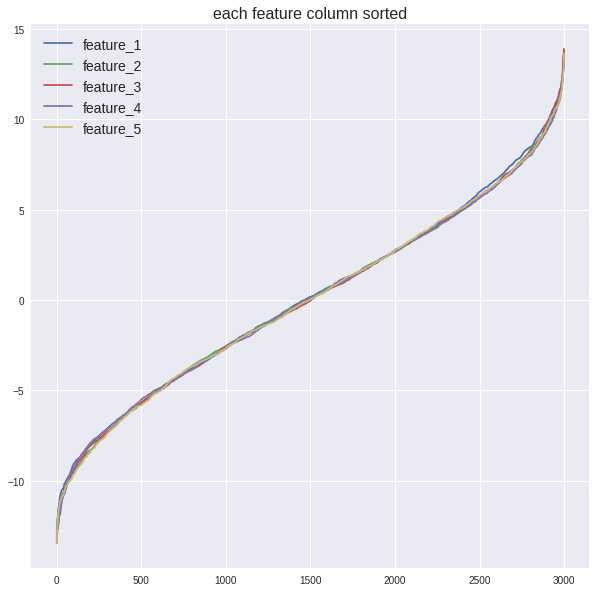

In [271]:
plt.plot(np.sort(X[:, 0], axis=0), label='feature_1')
plt.plot(np.sort(X[:, 1], axis=0), label='feature_2')
plt.plot(np.sort(X[:, 2], axis=0), label='feature_3')
plt.plot(np.sort(X[:, 3], axis=0), label='feature_4')
plt.plot(np.sort(X[:, 4], axis=0), label='feature_5')

plt.title('each feature column sorted', fontsize=16)
plt.legend(prop = {'size': 14})
plt.show()

Text(0.5,1,'Features distributions')

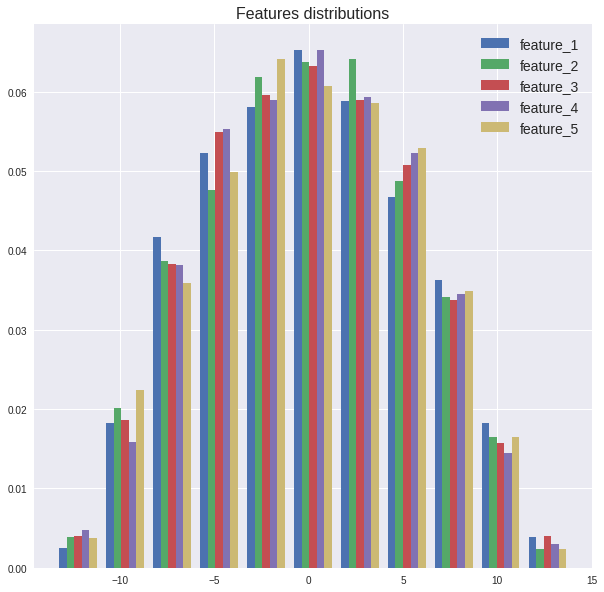

In [272]:
labels = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']
plt.hist(X, bins=11, density=True, histtype='bar', label=labels)
plt.legend(prop = {'size': 14})
plt.title('Features distributions', fontsize=16)

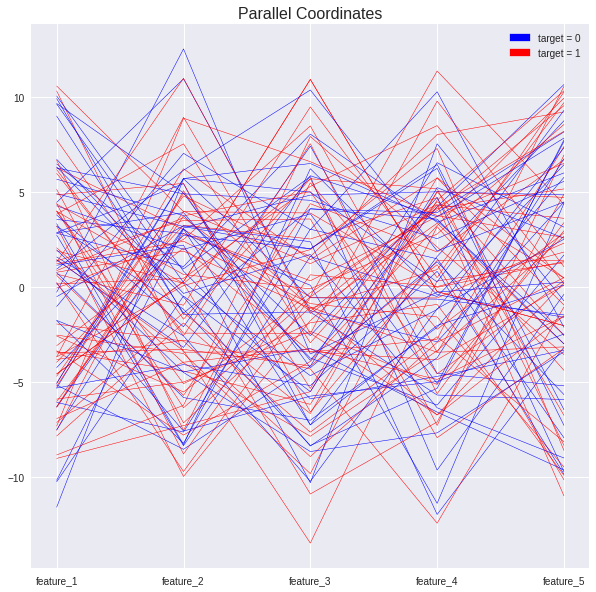

In [284]:
random_subset_idexes = np.random.choice(len(X), size=100)
for i in random_subset_idexes:
    if y[i] == 0:
        plt.plot(X[i], 'b-', lw=0.5)
    else:
        plt.plot(X[i], 'r-', lw=0.5)

plt.title('Parallel Coordinates', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='target = 0')
red_patch = mpatches.Patch(color='red', label='target = 1')
plt.legend(handles=[blue_patch, red_patch])
labels = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']
plt.xticks(range(5), labels)
plt.show()

# Data Preprocessing
- Долго пытался обучить разные типы классификаторов с различными параметрами на сырых необработанных данных
- Результаты были плохие `ROC-AUC` достигала максимум `0.55-0.6`
- использовал:
    - `np.abs`
    - `sklearn.preprocessing.scale`
    - `sklearn.preprocessing.normalize`
    - `sklearn.preprocessing.minmax_scale`
    - `sklearn.preprocessing.quantile_transform`
- Не помогло, `ROC-AUC` также была в районе  `0.5`
    
Попробывал возвести значения признаков **в квадрат**  
Качество классификации улучшилось значительно  
(для KNN, QDA и особенно для **SVM**)

In [0]:
X = np.square(X) # improves accuracy drastically

In [0]:
def test_classifier(classifier, X, y, algorithm_name):
    '''
    this function:
      - tests given classifier
      - uses 5-folds cross validation
      - plots ROC for each fold, mean ROC with ± 1 std
    
    based on:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    '''
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    folds = StratifiedKFold(n_splits=5).split(X, y)
    i = 0 
    for train, test in folds:
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])

        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:0.2f})')
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:0.2f} $\pm$ {std_auc:0.2f})', lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{algorithm_name} \n ROC (Receiver Operating Characteristic)')
    plt.legend(loc="lower right")
    plt.show()

# Testing Classifiers

In [0]:
algorithms = {
    'SVM'          : SVC(probability=True),
    'KNN'          : KNeighborsClassifier(3),
    'Naive Bayes'  : GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Net'   : MLPClassifier(),
    'AdaBoost'     : AdaBoostClassifier(),
    'QDA'          : QuadraticDiscriminantAnalysis(),
    'LDA'          : LinearDiscriminantAnalysis(),
    'GBC'          : GradientBoostingClassifier(),
}

# Support Vector Machines

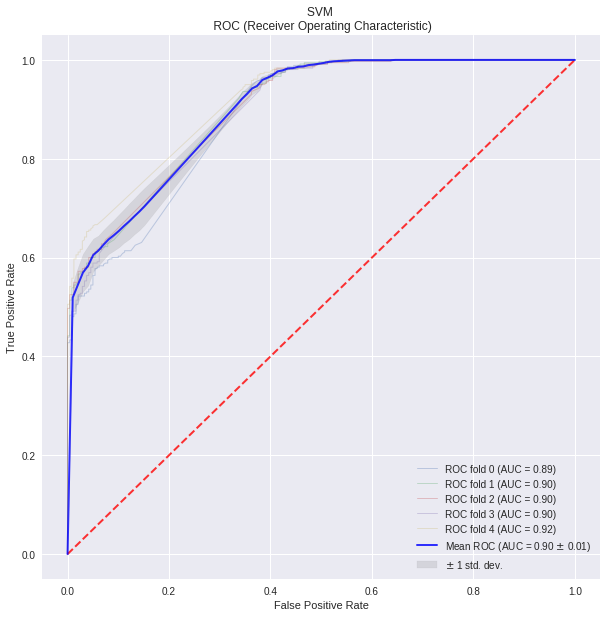

In [299]:
algorithm_name = 'SVM'
classifier = algorithms[algorithm_name]
test_classifier(classifier, X, y, algorithm_name=algorithm_name)

# K-Nearest Neighbors 

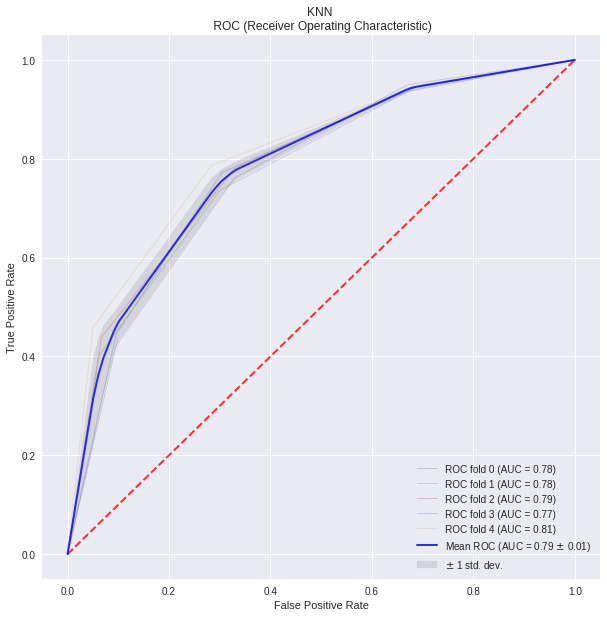

In [300]:
algorithm_name = 'KNN'
classifier = algorithms[algorithm_name]
test_classifier(classifier, X, y, algorithm_name=algorithm_name)

#  Naive Bayes

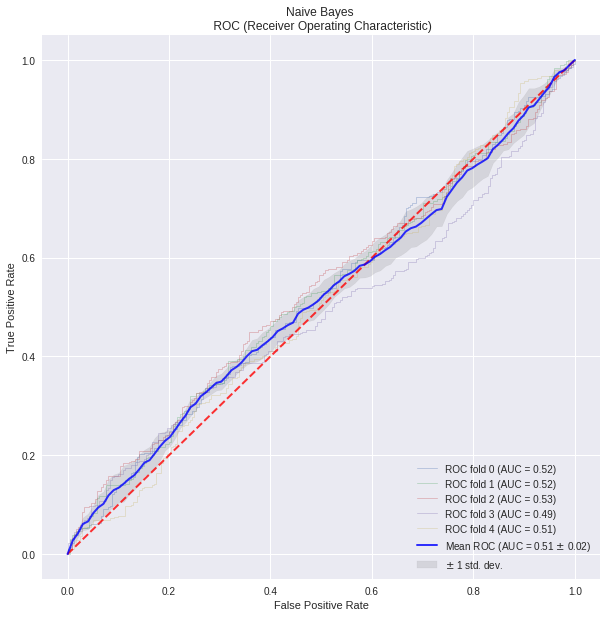

In [301]:
algorithm_name = 'Naive Bayes'
classifier =  algorithms[algorithm_name]
test_classifier(classifier, X, y, algorithm_name=algorithm_name)

# Decision Tree

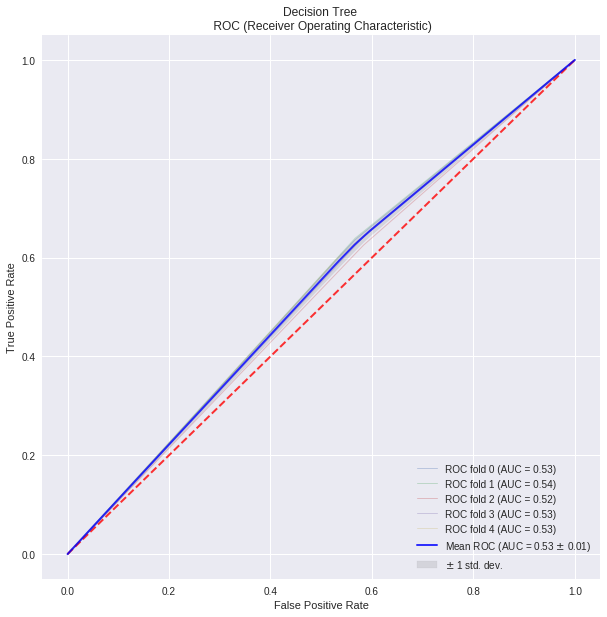

In [302]:
algorithm_name = 'Decision Tree'
classifier = algorithms[algorithm_name]
test_classifier(classifier, X, y, algorithm_name=algorithm_name)

# Random Forest

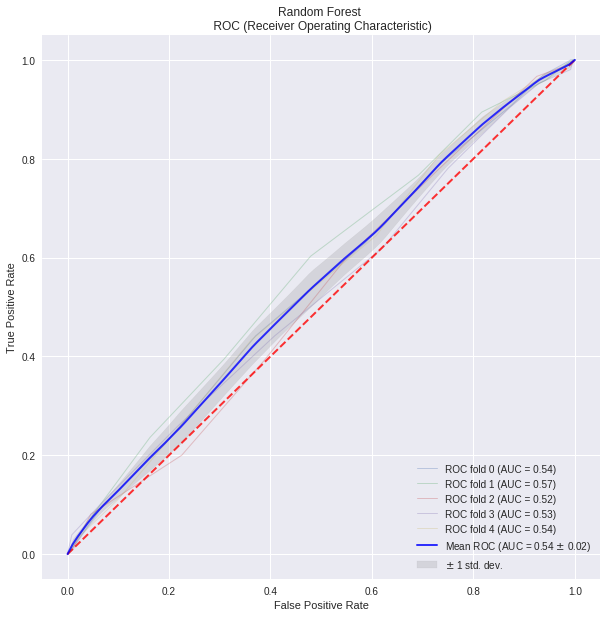

In [303]:
algorithm_name = 'Random Forest'
classifier = algorithms[algorithm_name]
test_classifier(classifier, X, y, algorithm_name=algorithm_name)

# Neural Net

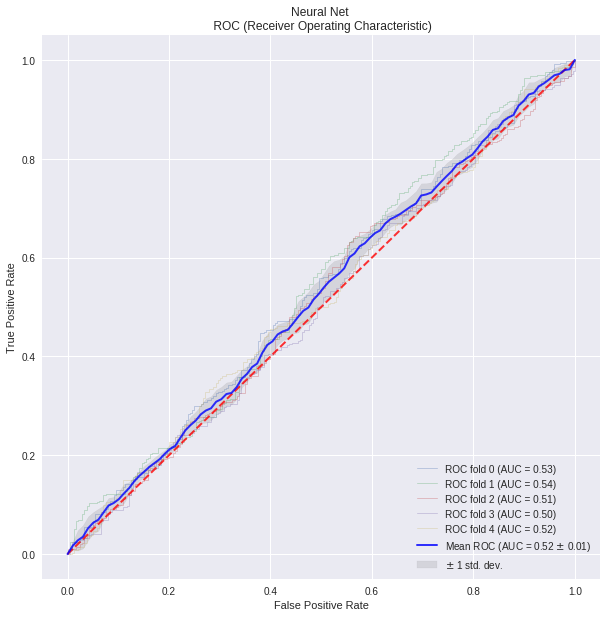

In [304]:
algorithm_name = 'Neural Net'
classifier = algorithms[algorithm_name]
test_classifier(classifier, X, y, algorithm_name=algorithm_name)

# Quadratic Discriminant Analysis

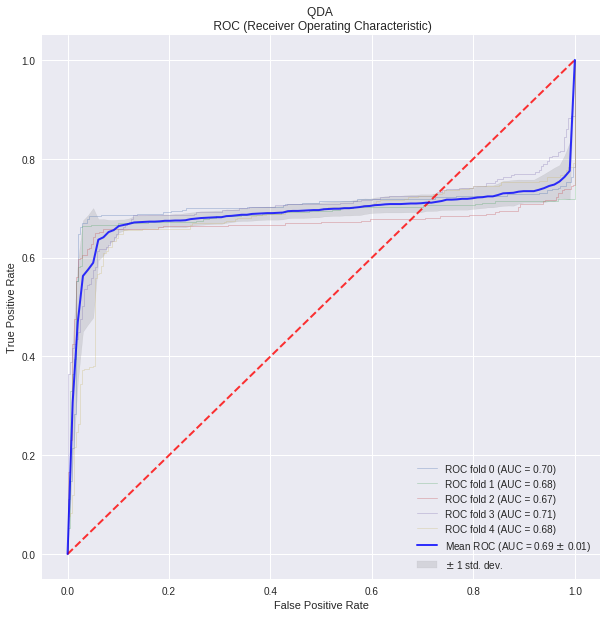

In [308]:
algorithm_name = 'QDA'
classifier = algorithms[algorithm_name]
test_classifier(classifier, X, y, algorithm_name=algorithm_name)

# Linear Discriminant Analysis

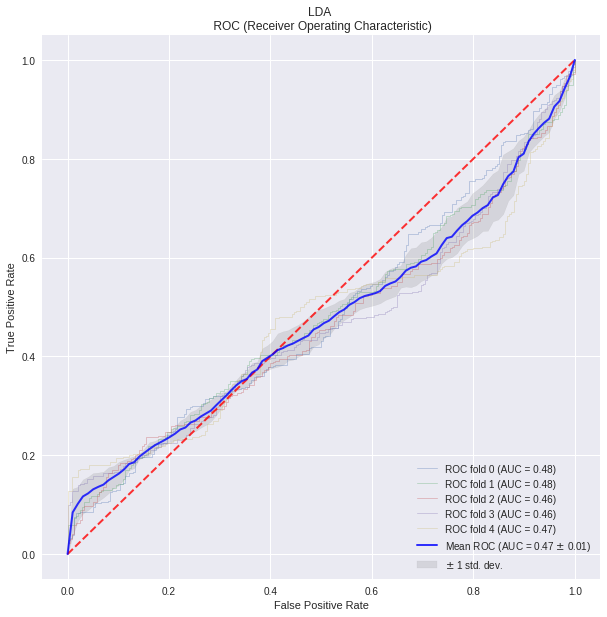

In [309]:
algorithm_name = 'LDA'
classifier = algorithms[algorithm_name]
test_classifier(classifier, X, y, algorithm_name=algorithm_name)

# Gradient Boosting

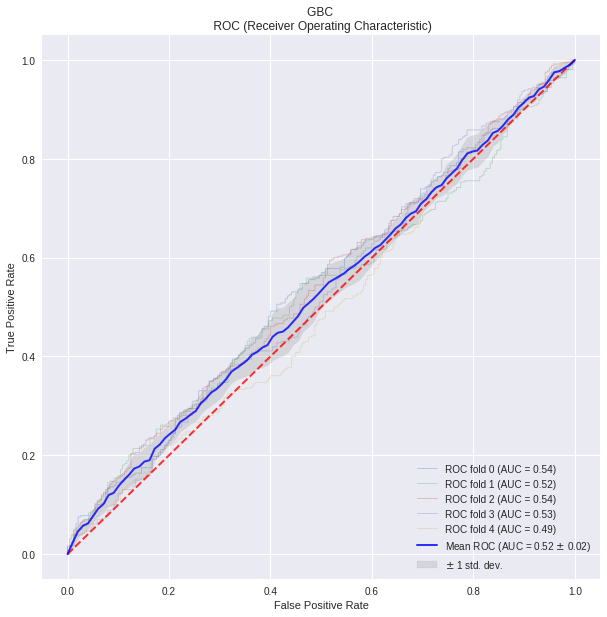

In [311]:
algorithm_name = 'GBC'
classifier = algorithms[algorithm_name]
test_classifier(classifier, X, y, algorithm_name=algorithm_name)

# AdaBoost

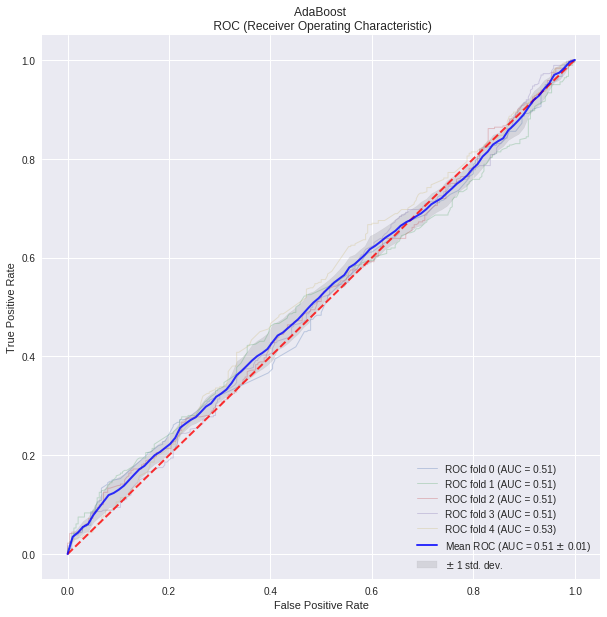

In [305]:
algorithm_name = 'AdaBoost'
classifier = algorithms[algorithm_name]
test_classifier(classifier, X, y, algorithm_name=algorithm_name)

# All Algorithms on in one picture
- ![all-algos](https://user-images.githubusercontent.com/5549677/45058480-8147f500-b0a1-11e8-922b-e48b26224190.jpg)

# Make test size as big as possible
- До текущего момента была использована 5-fold cross-validation (`StratifiedKFold`)
Соответсвенно размер тестовых данных составлял 1/5 датасета (20%)
- по заданию требовалось обучить классификатор с как можно более высокой обобщающей способностью
- попробуем увеличить размер тестовых данных и посмотрим как это будет влиять на качество классификации

SVM 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 KNN 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Naive Bayes 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Decision Tree 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 3

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


99 AdaBoost 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 QDA 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 LDA 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 GBC 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38

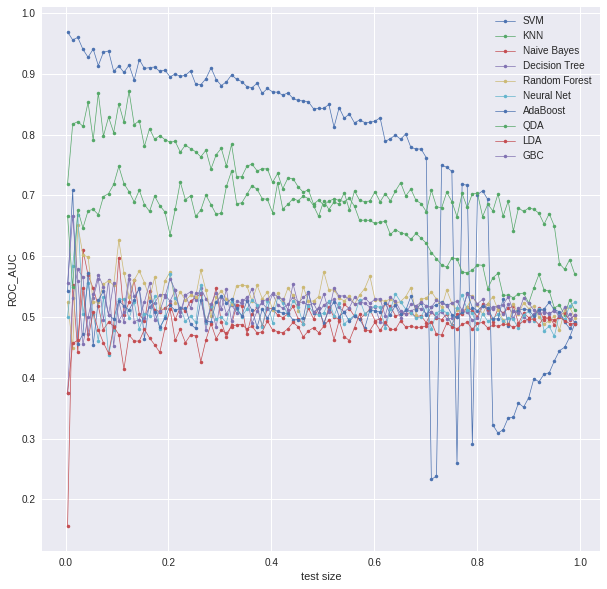

In [326]:
test_sizes = np.linspace(0.004, 0.99, 100)
roc_aucs = np.zeros_like(test_sizes)

for algorithm, classifier in algorithms.items():
    print(algorithm)
    for i, test_size in enumerate(test_sizes):
        print(i, end=' ')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        classifier.fit(X_train, y_train)
        y_score = classifier.predict_proba(X_test)[:,1]
        roc_aucs[i] = roc_auc_score(y_test, y_score)
        
    plt.plot(test_sizes, roc_aucs, '.-', lw=0.7, label=algorithm)
plt.legend()
plt.xlabel('test size')
plt.ylabel('ROC_AUC')
plt.show()

# Выводы
- препроцессинг исходных данных важен
- на данном датасете наилучшим образом работают алгоритмы SVM, KVM, QDA